
# Exploratory Data Analysis (EDA)
**Competition:** Toss NEXT ML Challenge: CTR Prediction (DACON)

This notebook performs a **practical, scalable EDA** on the provided parquet datasets.
The train file is large (~8GB), so the analysis **uses sampling by default**.
Adjust the parameters below if you want deeper scans.


In [2]:

# If pyarrow is missing, install it before running this notebook:
# !pip install pyarrow

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import (
    is_numeric_dtype,
    is_datetime64_any_dtype,
    is_bool_dtype,
    is_categorical_dtype,
)

try:
    import pyarrow as pa
    import pyarrow.parquet as pq
    import pyarrow.dataset as ds
except Exception as e:
    raise ImportError("pyarrow is required to read parquet files. Install with: pip install pyarrow") from e

from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
plt.style.use("seaborn-v0_8")
sns.set_context("notebook")


In [3]:

# Paths
DATA_DIR = "../data"
TRAIN_PATH = os.path.join(DATA_DIR, "train", "train.parquet")
TEST_PATH = os.path.join(DATA_DIR, "test", "test.parquet")
SUB_PATH = os.path.join(DATA_DIR, "submission", "sample_submission.csv")

assert os.path.exists(TRAIN_PATH), f"Missing: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH), f"Missing: {TEST_PATH}"
assert os.path.exists(SUB_PATH), f"Missing: {SUB_PATH}"

# Sampling configuration (tune if needed)
SAMPLE_ROWS = 50_000   # number of rows to load per split (train/test)
MAX_ROW_GROUPS = 4     # limit number of row groups to read
SEED = 42

def human_bytes(n):
    units = ["B", "KB", "MB", "GB", "TB"]
    i = 0
    while n >= 1024 and i < len(units) - 1:
        n /= 1024
        i += 1
    return f"{n:.2f} {units[i]}"

def parquet_meta(path):
    pf = pq.ParquetFile(path)
    meta = pf.metadata
    num_rows = meta.num_rows
    num_cols = meta.num_columns
    num_row_groups = meta.num_row_groups
    return pf, num_rows, num_cols, num_row_groups

for p in [TRAIN_PATH, TEST_PATH, SUB_PATH]:
    print(p, "->", human_bytes(os.path.getsize(p)))


../data/train/train.parquet -> 8.19 GB
../data/test/test.parquet -> 1.20 GB
../data/submission/sample_submission.csv -> 21.85 MB


In [4]:
# Load parquet metadata (no heavy read)
train_pf, train_rows, train_cols_count, train_rgs = parquet_meta(TRAIN_PATH)
test_pf, test_rows, test_cols_count, test_rgs = parquet_meta(TEST_PATH)

print(f"Train rows: {train_rows:,} | cols: {train_cols_count} | row groups: {train_rgs}")
print(f"Test  rows: {test_rows:,} | cols: {test_cols_count} | row groups: {test_rgs}")

train_cols = train_pf.schema.names
test_cols = test_pf.schema.names

submission = pd.read_csv(SUB_PATH)
sub_cols = submission.columns.tolist()

print("Sample submission columns:", sub_cols)


Train rows: 10,704,179 | cols: 119 | row groups: 1
Test  rows: 1,527,298 | cols: 119 | row groups: 1
Sample submission columns: ['ID', 'clicked']


In [5]:
# Infer target and id columns
# target is usually in train but NOT in test
potential_targets = sorted(set(train_cols) - set(test_cols))

target_col = None
if len(potential_targets) == 1:
    target_col = potential_targets[0]
else:
    # If submission has a non-id column, that may be the target
    non_id_cols = [c for c in sub_cols if c not in train_cols]
    # fallback: use a column in submission that's not obviously an id
    if len(sub_cols) >= 2:
        # heuristic: last column in submission often target
        guess = sub_cols[-1]
        if guess in train_cols:
            target_col = guess

# Identify id column (common to submission + train + test)
id_candidates = [c for c in sub_cols if c in train_cols and c in test_cols]
id_col = id_candidates[0] if len(id_candidates) == 1 else None

print("Target column:", target_col)
print("ID column:", id_col)
print("Potential targets (train-only cols):", potential_targets)


Target column: clicked
ID column: None
Potential targets (train-only cols): ['clicked']


In [6]:
train_df = pd.read_parquet(TRAIN_PATH)
test_df = pd.read_parquet(TEST_PATH)

In [7]:
# Basic overview
display(train_df.head())
display(test_df.head())

print("Train dtypes summary:", train_df.dtypes.value_counts())


,gender,age_group,inventory_id,day_of_week,hour,seq,l_feat_1,l_feat_2,l_feat_3,l_feat_4,l_feat_5,l_feat_6,l_feat_7,l_feat_8,l_feat_9,l_feat_10,l_feat_11,l_feat_12,l_feat_13,l_feat_14,l_feat_15,l_feat_16,l_feat_17,l_feat_18,l_feat_19,l_feat_20,l_feat_21,l_feat_22,l_feat_23,l_feat_24,l_feat_25,l_feat_26,l_feat_27,feat_e_1,feat_e_2,feat_e_3,feat_e_4,feat_e_5,feat_e_6,feat_e_7,feat_e_8,feat_e_9,feat_e_10,feat_d_1,feat_d_2,feat_d_3,feat_d_4,feat_d_5,feat_d_6,feat_c_1,feat_c_2,feat_c_3,feat_c_4,feat_c_5,feat_c_6,feat_c_7,feat_c_8,feat_b_1,feat_b_2,feat_b_3,feat_b_4,feat_b_5,feat_b_6,feat_a_1,feat_a_2,feat_a_3,feat_a_4,feat_a_5,feat_a_6,feat_a_7,feat_a_8,feat_a_9,feat_a_10,feat_a_11,feat_a_12,feat_a_13,feat_a_14,feat_a_15,feat_a_16,feat_a_17,feat_a_18,history_a_1,history_a_2,history_a_3,history_a_4,history_a_5,history_a_6,history_a_7,history_b_1,history_b_2,history_b_3,history_b_4,history_b_5,history_b_6,history_b_7,history_b_8,history_b_9,history_b_10,history_b_11,history_b_12,history_b_13,history_b_14,history_b_15,history_b_16,history_b_17,history_b_18,history_b_19,history_b_20,history_b_21,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30,clicked
0,1.0,7.0,36,5,13,"9,18,269,516,57,97,527,74,317,311,269,479,57,7...",1.0,2.0,1.0,23.0,1.0,1.0,193.0,2.0,50.0,118.0,743.0,2877.0,2.0,1591.0,1058.0,2.0,50.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1129.0,5.0,2.0,65.000000,-4230.666504,23.863636,-0.05,0.019608,-0.012987,0.6250,-242.488892,-0.612903,-436.228577,0.38961,2.0,1.764706,1.444444,-0.303030,-0.422535,58.840435,0.043634,66.696426,28.672052,45.806812,7.606154,73.891685,26.482759,4.845361,-4.337349,47.611111,0.907216,-75.421051,1961.083374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.4727,0.0,0.0,0.0,0.0,0.032765,-0.055556,0.024390,-326.857147,-0.014493,-183.285721,-13.596154,0.115821,0.138626,0.047507,0.050622,0.026479,0.001558,0.024922,0.051401,0.004673,0.021028,0.072428,0.007009,0.028816,0.058410,0.000779,0.072428,0.016355,0.011682,0.010124,0.002336,0.008567,0.070092,0.070092,0.011682,0.004673,0.087226,0.049843,0.015576,0.040498,0.051401,0
1,1.0,7.0,2,5,08,"9,144,269,57,516,97,527,74,315,317,311,269,479...",2.0,2.0,3.0,17.0,193.0,116.0,164.0,2.0,14.0,109.0,674.0,218.0,2.0,122.0,751.0,1.0,14.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1129.0,16.0,1.0,65.000000,-1346.648193,4.545455,-0.05,0.019608,-0.012987,104.6875,-194.066666,-52.709679,-390.728577,0.38961,2.0,1.764706,12.865979,-0.303030,-0.422535,58.840435,0.062986,23.371054,28.672052,31.121622,7.223301,73.891685,24.990477,4.432990,-4.469880,14.648149,0.927835,-34.771931,1195.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.7767,0.0,0.0,0.0,0.0,0.009340,0.000000,0.000000,-382.285706,0.000000,-176.000000,-11.442307,0.068794,0.072179,0.049471,0.052715,0.027574,0.001622,0.025952,0.053526,0.004866,0.021897,0.075423,0.007299,0.030007,0.060825,0.000811,0.075423,0.017031,0.012165,0.010543,0.002433,0.008921,0.072990,0.072990,0.012165,0.004866,0.045416,0.051904,0.016220,0.042172,0.026763,0
2,1.0,7.0,36,5,11,"269,516,57,97,165,527,74,77,317,269,75,450,15,...",1.0,2.0,1.0,7.0,675.0,85.0,227.0,2.0,362.0,212.0,1029.0,3916.0,1.0,2924.0,2304.0,2.0,362.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,1129.0,16.0,1.0,64.638885,-3195.388916,22.727272,-0.05,0.019608,-0.051948,13.6875,-305.844452,-12.677420,-600.885742,0.38961,2.0,1.764706,15.954545,-0.222222,-0.394366,58.840435,0.033670,43.445312,28.672052,41.673958,7.606154,73.891685,27.473171,4.402062,-0.819277,24.388889,0.917526,-67.701752,2386.083252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6597,0.0,0.0,0.0,0.0,0.078562,-0.111111,0.097561,-409.000000,-0.014493,-224.714279,-13.942307,0.112947,0.169634,0.038753,0.041295,0.021600,0.001271,0.020330,0.041930,0.003812,0.017153,0.059083,0.005718,0.023506,0.047647,0.000635,0.059083,0.026683,0.009530,0.008259,0.001906,0.006988,0.057177,0.057177,0.009530,0.003812,0.035577,0.081318,0.012706,0.033036,0.062898,0
3,1.0,8.0,37,5,11,"269,57,516,21,214,269

,ID,gender,age_group,inventory_id,day_of_week,hour,seq,l_feat_1,l_feat_2,l_feat_3,l_feat_4,l_feat_5,l_feat_6,l_feat_7,l_feat_8,l_feat_9,l_feat_10,l_feat_11,l_feat_12,l_feat_13,l_feat_14,l_feat_15,l_feat_16,l_feat_17,l_feat_18,l_feat_19,l_feat_20,l_feat_21,l_feat_22,l_feat_23,l_feat_24,l_feat_25,l_feat_26,l_feat_27,feat_e_1,feat_e_2,feat_e_3,feat_e_4,feat_e_5,feat_e_6,feat_e_7,feat_e_8,feat_e_9,feat_e_10,feat_d_1,feat_d_2,feat_d_3,feat_d_4,feat_d_5,feat_d_6,feat_c_1,feat_c_2,feat_c_3,feat_c_4,feat_c_5,feat_c_6,feat_c_7,feat_c_8,feat_b_1,feat_b_2,feat_b_3,feat_b_4,feat_b_5,feat_b_6,feat_a_1,feat_a_2,feat_a_3,feat_a_4,feat_a_5,feat_a_6,feat_a_7,feat_a_8,feat_a_9,feat_a_10,feat_a_11,feat_a_12,feat_a_13,feat_a_14,feat_a_15,feat_a_16,feat_a_17,feat_a_18,history_a_1,history_a_2,history_a_3,history_a_4,history_a_5,history_a_6,history_a_7,history_b_1,history_b_2,history_b_3,history_b_4,history_b_5,history_b_6,history_b_7,history_b_8,history_b_9,history_b_10,history_b_11,history_b_12,history_b_13,history_b_14,history_b_15,history_b_16,history_b_17,history_b_18,history_b_19,history_b_20,history_b_21,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30
0,TEST_0000000,2.0,6.0,46,7,13,"321,269,57,516,479,516,57,479,35,57,516,403,45...",2.0,2.0,2.0,19.0,1047.0,161.0,265.0,2.0,232.0,96.0,1513.0,4944.0,2.0,2065.0,1713.0,1.0,232.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1674.0,16.0,1.0,65.000000,-2554.314697,15.909091,-0.05,-0.058824,-0.285714,71.8750,-287.911102,-37.290321,-557.514282,0.389610,2.000000,1.764706,2.935484,-0.050505,-0.422535,58.808811,35.999840,78.856277,28.728247,44.657940,7.905045,73.918922,30.944529,4.412371,-2.192771,23.759260,0.917526,-54.929825,2452.416748,0.0,0.0,30.6,88.199997,85.590599,15.2,32.799999,0.0,80.0,0.0,0.0,0.0,0.0,6.3616,0.0,18.9,0.8,0.0,0.060337,-0.166667,0.060976,-355.000000,-0.043478,-180.428574,-13.326923,0.236312,0.281649,0.048257,0.051422,0.026897,0.001582,0.025315,0.052213,0.004747,0.021360,0.073572,0.014241,0.029271,0.059333,0.000791,0.073572,0.016613,0.011866,0.010284,0.007120,0.008702,0.071199,0.071199,0.011866,0.004747,0.044302,0.050630,0.015822,0.041137,0.104432
1,TEST_0000001,2.0,8.0,29,7,21,"57,35,479,57,463,212,193,151,463,193,74,77,207...",2.0,2.0,2.0,7.0,1024.0,297.0,47.0,2.0,220.0,57.0,1422.0,4758.0,1.0,1082.0,675.0,1.0,220.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1129.0,15.0,1.0,65.000000,-684.240723,6.818182,-0.05,-0.274510,-0.103896,18.6250,-144.355560,-11.795699,-281.242859,0.142857,1.400000,1.705882,39.000000,-0.050505,-0.366197,58.111111,1.307801,19.103174,24.386362,18.391304,4.952381,73.918922,6.186666,4.103093,-0.168675,7.814815,0.845361,-20.561403,451.250000,0.0,0.0,30.6,88.199997,75.611702,5.7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.6418,0.0,0.0,0.0,0.0,0.024875,0.000000,0.000000,-143.428574,0.000000,-63.857143,-3.942308,0.199030,0.198657,0.136158,0.145086,0.075891,0.004464,0.071427,0.147319,0.013393,0.060267,0.207585,0.020089,0.082588,0.167407,0.002232,0.207585,0.046874,0.033482,0.029017,0.006696,0.024553,0.200889,0.200889,0.033482,0.013393,0.124998,0.142854,0.044642,0.116069,0.073659
2,TEST_0000002,1.0,6.0,37,7,19,"57,516,97,74,527,77,318,315,317,311,269,479,57...",2.0,2.0,3.0,7.0,562.0,107.0,63.0,2.0,118.0,157.0,90.0,2100.0,2.0,1337.0,1329.0,1.0,118.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1129.0,11.0,1.0,64.638885,-2239.722168,4.318182,-0.05,0.019608,-0.025974,17.7500,-123.422226,-15.000000,-255.257141,0.389610,1.466667,1.647059,0.000000,-0.212121,-0.352113,55.417004,0.571350,11.250000,25.019608,29.525640,6.808511,73.918922,17.818182,4.329897,-3.216867,27.074074,0.876289,-39.315788,896.250000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,6.4981,0.0,0.0,0.0,0.0,0.031765,0.000000,0.000000,-112.285713,0.000000,-72.142860,-5.173077,0.151852,0.175891,0.120554,0.128459,0.067194,0.003953,0.063242,0.130436,0.011858,0.053360,0.183796,0.017787,0.073123,0.148223,0.001976,0.183796,0.041502,0.029645,0.025692,0.005929,0.021739,0.177867,0.177867,0

Train dtypes summary: float32    112
str          6
int32        1
Name: count, dtype: int64


In [8]:
# Feature type inference
def split_feature_types(df, target=None, cat_threshold=20):
    numeric, categorical, datetime = [], [], []
    for col in df.columns:
        if col == target:
            continue
        s = df[col]
        if is_datetime64_any_dtype(s):
            datetime.append(col)
        elif is_bool_dtype(s):
            categorical.append(col)
        elif is_numeric_dtype(s):
            # treat low-cardinality numeric as categorical
            nunique = s.nunique(dropna=True)
            if nunique <= cat_threshold:
                categorical.append(col)
            else:
                numeric.append(col)
        else:
            categorical.append(col)
    return numeric, categorical, datetime

num_cols, cat_cols, dt_cols = split_feature_types(train_df, target=target_col)

print(f"Numeric: {len(num_cols)}")
print(f"Categorical: {len(cat_cols)}")
print(f"Datetime: {len(dt_cols)}")


Numeric: 80
Categorical: 38
Datetime: 0


,missing_rate,missing_count
age_group,0.001608,17208
clicked,0.000000,0
day_of_week,0.000000,0
feat_a_1,0.001737,18598
feat_a_10,0.001737,18598
feat_a_11,0.001737,18598
feat_a_12,0.001737,18598
feat_a_13,0.001737,18598
feat_a_14,0.001737,18598
feat_a_15,0.001737,18598


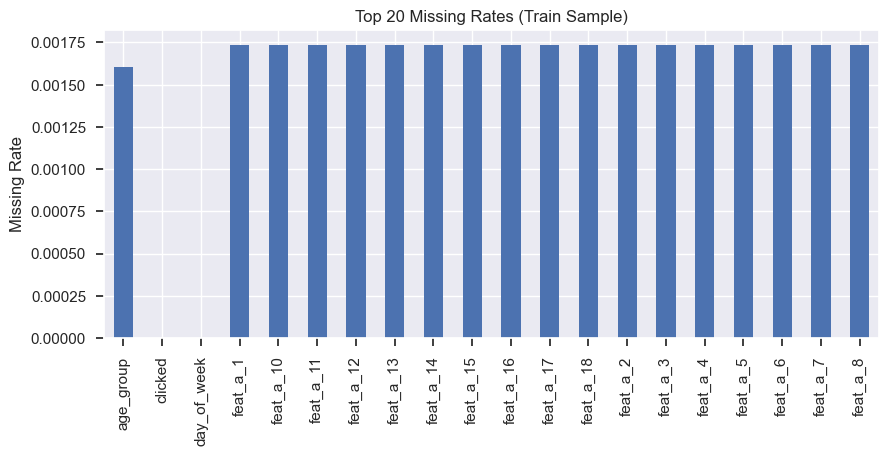

In [9]:
# Missingness
def missing_summary(df):
    miss = df.isna().mean().sort_values(ascending=False)
    return pd.DataFrame({"missing_rate": miss, "missing_count": df.isna().sum()})

miss_train = missing_summary(train_df)
display(miss_train.head(20))

plt.figure(figsize=(10, 4))
miss_train.head(20)["missing_rate"].plot(kind="bar")
plt.title("Top 20 Missing Rates (Train Sample)")
plt.ylabel("Missing Rate")
plt.show()

In [ ]:

# Duplicate rows (sample)
dup_count = train_df.duplicated().sum()
print(f"Duplicate rows in train sample: {dup_count} ({dup_count/len(train_df):.2%})")


clicked
0    10500000
1      204179
Name: count, dtype: int64

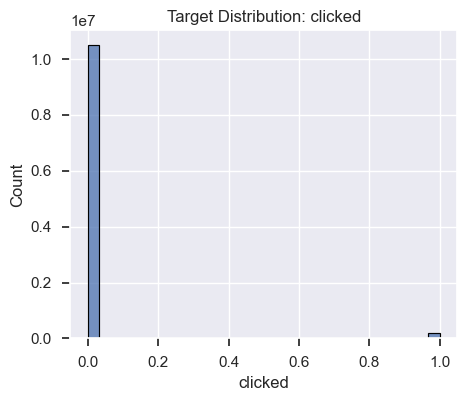

Positive rate (sample): 0.0191


In [10]:

# Target distribution (if found)
if target_col and target_col in train_df.columns:
    tgt = train_df[target_col]
    display(tgt.value_counts(dropna=False))

    plt.figure(figsize=(5, 4))
    sns.histplot(tgt, bins=30, kde=False)
    plt.title(f"Target Distribution: {target_col}")
    plt.show()

    # If binary, show positive rate
    if tgt.dropna().nunique() <= 2:
        pos_rate = tgt.mean()
        print(f"Positive rate (sample): {pos_rate:.4f}")
else:
    print("Target column not confidently identified. Please set target_col manually.")


,count,mean,std,min,25%,50%,75%,max
l_feat_4,10704179.0,9.543341,5.946347,1.000000,7.000000,7.000000,12.000000,26.000000
l_feat_5,10704179.0,393.810608,289.993042,1.000000,105.000000,376.000000,652.000000,1079.000000
l_feat_6,10704179.0,314.788147,231.329376,1.000000,109.000000,278.000000,471.000000,903.000000
l_feat_7,10704179.0,147.909637,71.926926,1.000000,94.000000,146.000000,212.000000,313.000000
l_feat_9,10704179.0,212.802612,125.103279,1.000000,101.000000,224.000000,309.000000,476.000000
l_feat_10,10704179.0,123.944603,62.090584,1.000000,83.000000,125.000000,179.000000,262.000000
l_feat_11,10704179.0,623.435486,392.166260,1.000000,288.000000,595.000000,949.000000,1527.000000
l_feat_12,10704179.0,2348.137695,1541.107178,1.000000,878.000000,2247.000000,3916.000000,5061.000000
l_feat_14,10704179.0,1906.626221,978.614441,1.000000,1055.000000,2114.000000,2924.000000,3245.000000
l_feat_15,10704179.0,1298.295166,787.268311,1.000000,613.000000,1190.000000,2304.000000,2590.000000


history_a_1     0.068000
history_a_2    -0.060412
history_a_3     0.059675
history_a_5    -0.059130
history_b_2     0.059034
history_b_30    0.057875
history_b_1     0.051917
feat_b_4       -0.048458
history_b_10    0.048412
feat_d_3       -0.046677
feat_e_1       -0.045638
history_b_17    0.044046
history_b_15    0.043015
history_b_9     0.042772
history_b_3     0.042717
history_b_20    0.042627
history_b_27    0.042265
history_b_28    0.042062
history_b_5     0.042018
history_b_26    0.041886
Name: clicked, dtype: float64

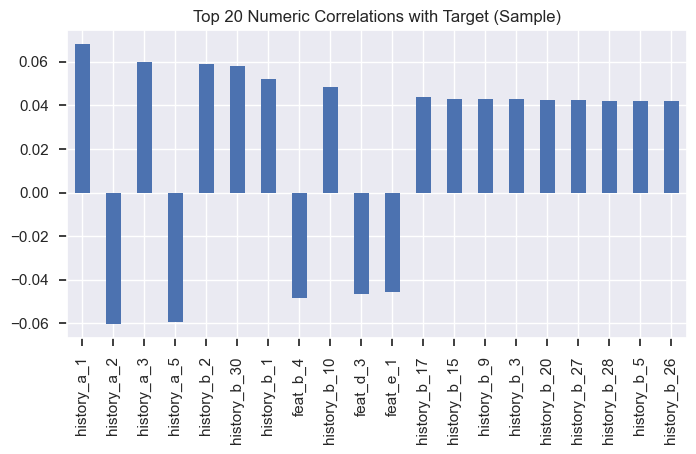

In [11]:

# Numeric feature summary
if num_cols:
    display(train_df[num_cols].describe().T.head(30))

    # Correlation with target (if numeric + target exists)
    if target_col and target_col in train_df.columns and is_numeric_dtype(train_df[target_col]):
        corr = train_df[num_cols + [target_col]].corr()[target_col].drop(target_col)
        corr = corr.sort_values(key=lambda s: s.abs(), ascending=False)
        display(corr.head(20))

        plt.figure(figsize=(8, 4))
        corr.head(20).plot(kind="bar")
        plt.title("Top 20 Numeric Correlations with Target (Sample)")
        plt.show()


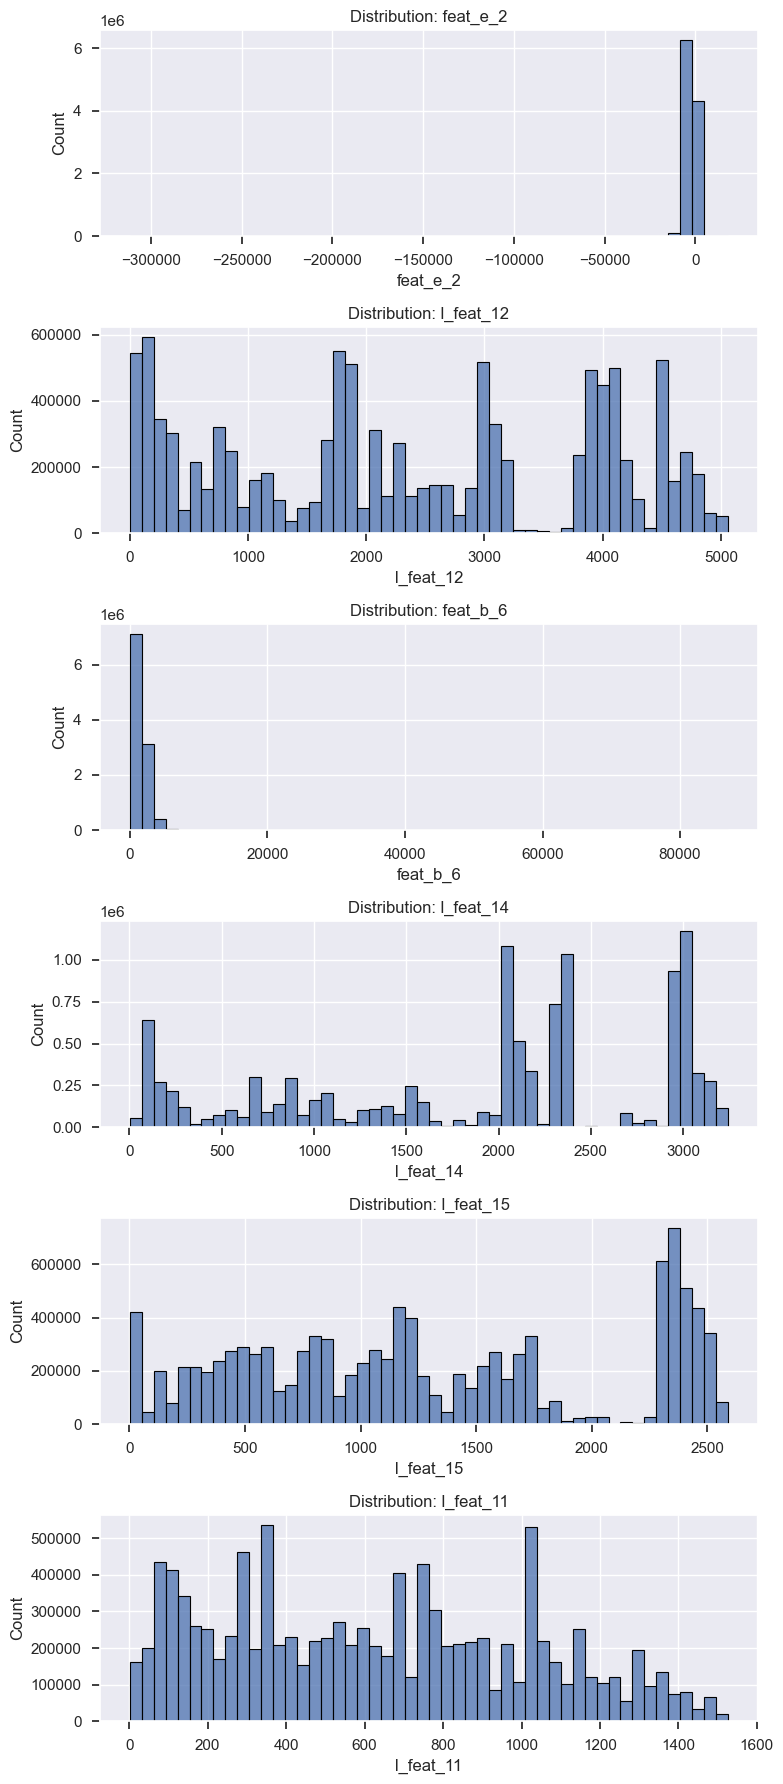

In [12]:

# Numeric distribution plots (top variance features)
if num_cols:
    variances = train_df[num_cols].var().sort_values(ascending=False)
    top_num = variances.head(6).index.tolist()

    fig, axes = plt.subplots(len(top_num), 1, figsize=(8, 3 * len(top_num)), sharex=False)
    if len(top_num) == 1:
        axes = [axes]
    for ax, col in zip(axes, top_num):
        sns.histplot(train_df[col], bins=50, kde=False, ax=ax)
        ax.set_title(f"Distribution: {col}")
    plt.tight_layout()
    plt.show()


In [ ]:

# Categorical summary
if cat_cols:
    cat_summary = pd.DataFrame({
        "nunique": train_df[cat_cols].nunique(dropna=True),
        "missing_rate": train_df[cat_cols].isna().mean(),
    }).sort_values("nunique", ascending=False)

    display(cat_summary.head(30))

    # Top categories for a few columns
    for col in cat_summary.head(5).index:
        print(f" Top categories: {col}")
        display(train_df[col].value_counts(dropna=False).head(10))


In [ ]:

    # Target rate by top categories (if target exists)
    if target_col and target_col in train_df.columns and cat_cols:
        for col in cat_cols[:5]:
            tmp = train_df[[col, target_col]].dropna()
            if tmp[col].nunique() > 50:
                tmp = tmp[tmp[col].isin(tmp[col].value_counts().head(20).index)]

            rate = tmp.groupby(col)[target_col].mean().sort_values(ascending=False)
            print(f"
Target mean by category: {col}")
            display(rate.head(20))


In [ ]:

# Train vs Test drift (sample-based)
drift_results = []

# Numeric drift via KS
for col in num_cols:
    a = train_df[col].dropna()
    b = test_df[col].dropna()
    if len(a) > 0 and len(b) > 0:
        stat = ks_2samp(a, b).statistic
        drift_results.append((col, "numeric", stat))

# Categorical drift via Jensen-Shannon
for col in cat_cols:
    a = train_df[col].astype(str).fillna("<NA>")
    b = test_df[col].astype(str).fillna("<NA>")
    a_dist = a.value_counts(normalize=True)
    b_dist = b.value_counts(normalize=True)
    # align index
    all_idx = a_dist.index.union(b_dist.index)
    a_vec = a_dist.reindex(all_idx, fill_value=0).values
    b_vec = b_dist.reindex(all_idx, fill_value=0).values
    js = jensenshannon(a_vec, b_vec)
    drift_results.append((col, "categorical", js))

drift_df = pd.DataFrame(drift_results, columns=["feature", "type", "drift_score"]).sort_values("drift_score", ascending=False)
display(drift_df.head(30))



## Notes
- This EDA uses **sampling** to keep memory usage reasonable on large parquet files.
- Increase `SAMPLE_ROWS` or `MAX_ROW_GROUPS` for a deeper scan.
- If you want **full-dataset statistics**, consider using DuckDB or PyArrow datasets with aggregations.
